# Install and Import Packages

In [1]:
!pip3 install shapely==1.7.1
!pip install rasterio
!pip install albumentations
!pip install pytorch_metric_learning
!pip install timm
!pip install imageio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shapely: filename=Shapely-1.7.1-cp310-cp310-linux_x86_64.whl size=602599 sha256=60ac55cb2bfd2f76b2dd59247a9780b2d8d44232f0a40757a13fbd3420eebc9a
  Stored in directory: /root/.cache/pip/wheels/2e/fa/97/c85f587c35afcaf4a81c481741d36592518d1e50445572f0d4
Successfully built shapely
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.4 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

### TODO: remove unused imports after finalizing notebook

In [3]:
# from model.resnet import *
# from model.effnet import *
# from model.unet import *
# from utils.metrics import *
# from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
# from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import pickle
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore")

# Mounting dataset from GDrive

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# dataset_path = '/content/drive/My Drive/input/forestnet'

### Extracting dataset zip file into colab's storage
 - This will be beneficial during training because loading each image from gdrive was too slow

In [6]:
from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/My Drive/ForestNetDataset.zip'  # Change this to your actual file path

import zipfile
import os

# Create a directory to extract the contents
extracted_folder = '/input'  # Change this if you want a different name
os.makedirs(extracted_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print(f'Contents extracted to {extracted_folder}')


Mounted at /content/drive
Contents extracted to /input


# Importing packages

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import skimage.draw as sk
import torch
from fastai.vision.all import *
from fastai.imports import *

# Examining Dataset

### Ensure data is formatted properly

In [105]:
dataset_path = '/input/deep/downloads'

train_df = pd.read_csv(f'{dataset_path}/ForestNetDataset/train.csv')
val_df = pd.read_csv(f'{dataset_path}/ForestNetDataset/val.csv')
test_df = pd.read_csv(f'{dataset_path}/ForestNetDataset/test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Timber plantation,Plantation,4.430849,96.101634,2014,examples/4.430849118860583_96.1016343478138
1,Other,Other,1.332341,109.374229,2012,examples/1.3323406178609702_109.37422873130464
2,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,examples/-1.720266384577504_115.00699582064485
3,Small-scale agriculture,Smallholder agriculture,-2.248346,104.135786,2011,examples/-2.248346072674411_104.1357857482906
4,Other large-scale plantations,Plantation,-2.100800,113.022376,2008,examples/-2.100800102991412_113.0223763234016


### Datset Distribution Plot

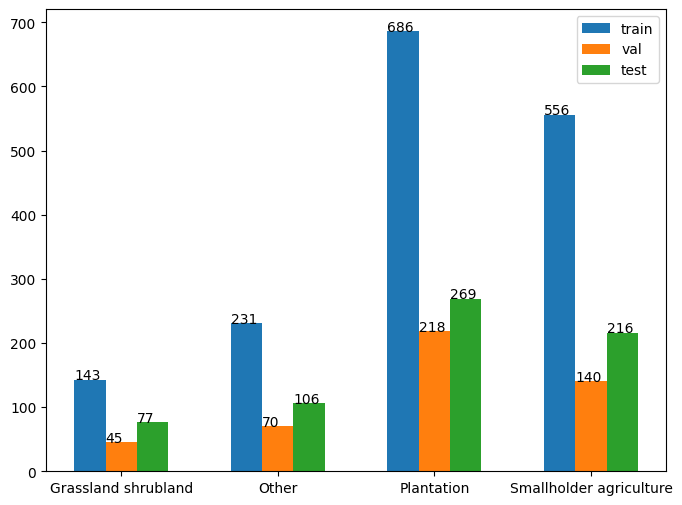

In [106]:
# Plot distribution of data
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

### TODO: More graphs and/or Sample images ?

# Creating A Custom Dataset Class
### This allows auxiliary data to be loaded along with the images and masks



### TODO: Add aux to dataset class
### TODO: Di ko pa nalagay yung find closest image ni Dhea

In [107]:
import imageio

class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir=f'{dataset_path}/ForestNetDataset', transform=None, types="classifier"):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {'Grassland shrubland':0, 'Other':1, 'Plantation':2, 'Smallholder agriculture':3}
        self.types = types

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]

        ## Load the image and auxiliary
        image_path = f'{self.root_dir}/{folder}/images/visible/composite.png'.replace(' ', '')
        image = imageio.imread(image_path)

        slope_path = f'{self.root_dir}/{folder}/auxiliary/gfc.npy'.replace(' ', '')
        slope = np.load(slope_path)

        ## Get the segmentation map
        segmentation_path = f'{self.root_dir}/{folder}/forest_loss_region.pkl'.replace(' ', '')
        with open(segmentation_path, 'rb') as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)

        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        mask = rasterize(shapes=poly_shp, out_shape=(332,332))
        seg = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, merged_label
        else:
            return image, seg, merged_label


### TODO: Show what the data in the batch looks like? parang yung show_batch dun sa previous architecture. Not sure pa if pwede

# Model Training

### Initialize Hyperparameters

In [108]:
# Initialize several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
nbClass = 4

### Load the training, validation and test data

In [109]:
# Load Dataset and Create DataLoader For Classification
train_dataset = ForestDataset( csv_file_to_df=train_df)
val_dataset = ForestDataset( csv_file_to_df=val_df)
test_dataset = ForestDataset( csv_file_to_df=test_df)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

### Sanity Check to ensure proper tensor shapes

In [110]:
dataiter = iter(trainloader)
images, seg, labels = next(dataiter)

print('images shape on PyTroch : ', images.size())
# print('slope shape on PyTroch : ', slope.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([16, 3, 160, 160])
labels shape on PyTroch :  torch.Size([16])


In [111]:
sample = next(iter(trainloader))[1]
print(sample.shape)

sample_target = next(iter(valloader))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


### Define the Model (FPN With EfficientNet Backbone)

In [112]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b2

class FPN(nn.Module):
    def __init__(self, n_segmentation_classes, n_classification_classes, pretrained=True, dropout_rate=0.5):
        super(FPN, self).__init__()

        # Load EfficientNet backbone
        backbone = efficientnet_b2(pretrained=pretrained)
        self.stem = nn.Sequential(*list(backbone.features[:2]))  # 16 channels
        self.layer1 = nn.Sequential(*list(backbone.features[2:4]))  # 48 channels
        self.layer2 = nn.Sequential(*list(backbone.features[4:6]))  # 120 channels
        self.layer3 = nn.Sequential(*list(backbone.features[6:]))   # 1408 channels

        # Adjust channel sizes for FPN layers
        self.p3 = nn.Conv2d(1408, 256, kernel_size=1)  # From c4
        self.p2 = nn.Conv2d(120, 128, kernel_size=1)    # From c3
        self.p1 = nn.Conv2d(48, 64, kernel_size=1)      # From c2

        # Dropout layers
        self.dropout = nn.Dropout(dropout_rate)

        # Upsampling + Convolution Layers
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 5x5 -> 10x10
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 10x10 -> 20x20
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)     # 20x20 -> 40x40
        self.final_upsample = nn.ConvTranspose2d(64, n_segmentation_classes, kernel_size=2, stride=2)  # 40x40 -> 80x80

        # Convolution block for segmentation
        self.segmentation_head = nn.Conv2d(64, n_segmentation_classes, kernel_size=1)

        # Fully connected layer for classification
        self.classification_head = nn.Linear(1408 * 5 * 5, n_classification_classes)

    def forward(self, x):
        # EfficientNet backbone
        c1 = self.stem(x)     # First stage (16 channels)
        c2 = self.layer1(c1)  # Second stage (48 channels)
        c3 = self.layer2(c2)  # Third stage (120 channels)
        c4 = self.layer3(c3)  # Final stage (1408 channels)

        # Feature Pyramid
        p3 = self.p3(c4)  # c4 feature map
        p2 = self.p2(c3)  # c3 feature map
        p1 = self.p1(c2)  # c2 feature map

        # Upsampling and combining
        p2 = p2 + self.upsample3(p3)  # Combine p2 with upsampled p3
        p1 = p1 + self.upsample2(p2)  # Combine p1 with upsampled p2

        # Now apply an additional upsampling layer to reach 80x80 and then one more to get to 160x160
        segmentation_output = self.final_upsample(p1)  # Final output (40x40 -> 80x80)
        segmentation_output = nn.functional.interpolate(segmentation_output, size=(160, 160), mode='bilinear', align_corners=False)  # Upsample to 160x160

        # Classification output (from final layer)
        c4_flat = torch.flatten(c4, start_dim=1)
        c4_flat = self.dropout(c4_flat)  # Apply dropout before the classification head
        classification_output = self.classification_head(c4_flat)

        return classification_output, segmentation_output


### Initialize the model for training


### TODO: Finalize yung batch, LR, loss functions na gagamitin, same na dapat with forestnet

In [113]:
# Define the number of input channels and output classes
n_channels = 3  # RGB satellite images
n_segmentation_classes = 4  # Number of segmentation classes
n_classification_classes = 4  # Number of classification classes

# Initialize your FPN with EfficientNet Backbone model
fpn_model = FPN(n_segmentation_classes=n_segmentation_classes, n_classification_classes=n_classification_classes)
model = fpn_model.to(device)

# Define the loss functions
criterion_classifier = nn.CrossEntropyLoss()
criterion_segmentation = nn.CrossEntropyLoss()

# Define the optimizer (same as before)
optimizer = optim.Adam(fpn_model.parameters(), lr=1e-4)

# Print the model to verify
print(fpn_model)


FPN(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
        

### Sanity Check to test if data fits in the model

In [114]:
# Sample test with random input
sample_images = torch.randn(16, 3, 160, 160)  # Replace with your actual input tensor
model.eval()
with torch.no_grad():
    classification_output, segmentation_output = model(sample_images)
    print("Classification Output Shape:", classification_output.shape)
    print("Segmentation Output Shape:", segmentation_output.shape)

Classification Output Shape: torch.Size([16, 4])
Segmentation Output Shape: torch.Size([16, 4, 160, 160])


### Training Loop


### TODO: Might need to add save best epoch, lr scheduler, early stopping etc.

In [115]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# Initialize lists for metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    # Wrap the training data loader with tqdm
    train_loop = tqdm(trainloader, total=len(trainloader), desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

    for image, seg, merged_label in train_loop:
        images = image.to(device)
        segmentation_masks = F.one_hot(seg.long(), num_classes=n_segmentation_classes).permute(0, 3, 1, 2).float().to(device)
        segmentation_targets = seg.long().to(device)  # Targets should be class indices (LongTensor)
        labels = merged_label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: get outputs from the model
        classification_output, segmentation_output = model(images)

        # Compute losses
        loss_classifier = criterion_classifier(classification_output, labels)  # Classification loss
        loss_segmentation = criterion_segmentation(segmentation_output, segmentation_targets)  # Segmentation loss

        # Combine losses
        loss = loss_classifier + loss_segmentation

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Collect predictions for metrics
        preds = torch.argmax(classification_output, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Update tqdm progress bar
        train_loop.set_postfix(loss=loss.item())

    # Calculate training metrics
    train_loss = running_loss / len(trainloader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Print training metrics after the epoch
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}')

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    val_all_labels = []
    val_all_preds = []

    with torch.no_grad():
        for image, seg, merged_label in valloader:
            images = image.to(device)
            segmentation_masks = F.one_hot(seg.long(), num_classes=n_segmentation_classes).permute(0, 3, 1, 2).float().to(device)
            segmentation_targets = seg.long().to(device)  # Targets should be class indices (LongTensor)
            labels = merged_label.to(device)

            # Forward pass
            classification_output, segmentation_output = model(images)

            # Compute losses
            loss_classifier = criterion_classifier(classification_output, labels)
            loss_segmentation = criterion_segmentation(segmentation_output, segmentation_targets)
            total_loss = loss_classifier + loss_segmentation

            # Update validation loss
            running_val_loss += total_loss.item()

            # Collect predictions for metrics
            preds = torch.argmax(classification_output, dim=1)
            val_all_labels.extend(labels.cpu().numpy())
            val_all_preds.extend(preds.cpu().numpy())

    # Calculate validation metrics
    val_loss = running_val_loss / len(valloader)
    val_accuracy = accuracy_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds, average='weighted')

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation metrics after the epoch
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}')



Epoch [1/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=1.66]



Epoch [1/20]
Train Loss: 3.0971, Train Accuracy: 0.5835, Train F1 Score: 0.5707
Validation Loss: 1.8391, Validation Accuracy: 0.6998, Validation F1 Score: 0.6963


Epoch [2/20]: 100%|██████████| 101/101 [01:07<00:00,  1.49it/s, loss=1.26]



Epoch [2/20]
Train Loss: 1.3732, Train Accuracy: 0.7748, Train F1 Score: 0.7700
Validation Loss: 1.4366, Validation Accuracy: 0.7336, Validation F1 Score: 0.7345


Epoch [3/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=0.771]



Epoch [3/20]
Train Loss: 0.9585, Train Accuracy: 0.8552, Train F1 Score: 0.8541
Validation Loss: 1.2716, Validation Accuracy: 0.7378, Validation F1 Score: 0.7370


Epoch [4/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=0.859]



Epoch [4/20]
Train Loss: 0.7311, Train Accuracy: 0.9109, Train F1 Score: 0.9104
Validation Loss: 1.2121, Validation Accuracy: 0.7717, Validation F1 Score: 0.7693


Epoch [5/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=0.476]



Epoch [5/20]
Train Loss: 0.5706, Train Accuracy: 0.9585, Train F1 Score: 0.9584
Validation Loss: 1.1712, Validation Accuracy: 0.7717, Validation F1 Score: 0.7693


Epoch [6/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=0.613]



Epoch [6/20]
Train Loss: 0.5185, Train Accuracy: 0.9511, Train F1 Score: 0.9511
Validation Loss: 1.1857, Validation Accuracy: 0.7463, Validation F1 Score: 0.7463


Epoch [7/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=0.39]



Epoch [7/20]
Train Loss: 0.4365, Train Accuracy: 0.9752, Train F1 Score: 0.9752
Validation Loss: 1.1865, Validation Accuracy: 0.7611, Validation F1 Score: 0.7589


Epoch [8/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.518]



Epoch [8/20]
Train Loss: 0.3962, Train Accuracy: 0.9790, Train F1 Score: 0.9790
Validation Loss: 1.1786, Validation Accuracy: 0.7569, Validation F1 Score: 0.7535


Epoch [9/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.404]



Epoch [9/20]
Train Loss: 0.3782, Train Accuracy: 0.9808, Train F1 Score: 0.9808
Validation Loss: 1.2088, Validation Accuracy: 0.7484, Validation F1 Score: 0.7457


Epoch [10/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.308]



Epoch [10/20]
Train Loss: 0.3568, Train Accuracy: 0.9802, Train F1 Score: 0.9802
Validation Loss: 1.2253, Validation Accuracy: 0.7632, Validation F1 Score: 0.7618


Epoch [11/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.382]



Epoch [11/20]
Train Loss: 0.3481, Train Accuracy: 0.9821, Train F1 Score: 0.9820
Validation Loss: 1.2513, Validation Accuracy: 0.7653, Validation F1 Score: 0.7641


Epoch [12/20]: 100%|██████████| 101/101 [01:09<00:00,  1.46it/s, loss=0.217]



Epoch [12/20]
Train Loss: 0.3317, Train Accuracy: 0.9858, Train F1 Score: 0.9857
Validation Loss: 1.2461, Validation Accuracy: 0.7674, Validation F1 Score: 0.7641


Epoch [13/20]: 100%|██████████| 101/101 [01:09<00:00,  1.46it/s, loss=0.324]



Epoch [13/20]
Train Loss: 0.3272, Train Accuracy: 0.9858, Train F1 Score: 0.9858
Validation Loss: 1.2775, Validation Accuracy: 0.7611, Validation F1 Score: 0.7599


Epoch [14/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=0.273]



Epoch [14/20]
Train Loss: 0.3038, Train Accuracy: 0.9901, Train F1 Score: 0.9901
Validation Loss: 1.3183, Validation Accuracy: 0.7526, Validation F1 Score: 0.7499


Epoch [15/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.256]



Epoch [15/20]
Train Loss: 0.2985, Train Accuracy: 0.9895, Train F1 Score: 0.9895
Validation Loss: 1.3204, Validation Accuracy: 0.7590, Validation F1 Score: 0.7559


Epoch [16/20]: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, loss=0.24]



Epoch [16/20]
Train Loss: 0.2901, Train Accuracy: 0.9889, Train F1 Score: 0.9889
Validation Loss: 1.3227, Validation Accuracy: 0.7569, Validation F1 Score: 0.7571


Epoch [17/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.375]



Epoch [17/20]
Train Loss: 0.2877, Train Accuracy: 0.9876, Train F1 Score: 0.9876
Validation Loss: 1.4052, Validation Accuracy: 0.7294, Validation F1 Score: 0.7259


Epoch [18/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.307]



Epoch [18/20]
Train Loss: 0.2758, Train Accuracy: 0.9907, Train F1 Score: 0.9907
Validation Loss: 1.3300, Validation Accuracy: 0.7548, Validation F1 Score: 0.7534


Epoch [19/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.232]



Epoch [19/20]
Train Loss: 0.2809, Train Accuracy: 0.9876, Train F1 Score: 0.9876
Validation Loss: 1.3771, Validation Accuracy: 0.7632, Validation F1 Score: 0.7615


Epoch [20/20]: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s, loss=0.21]



Epoch [20/20]
Train Loss: 0.2636, Train Accuracy: 0.9882, Train F1 Score: 0.9882
Validation Loss: 1.3931, Validation Accuracy: 0.7611, Validation F1 Score: 0.7570


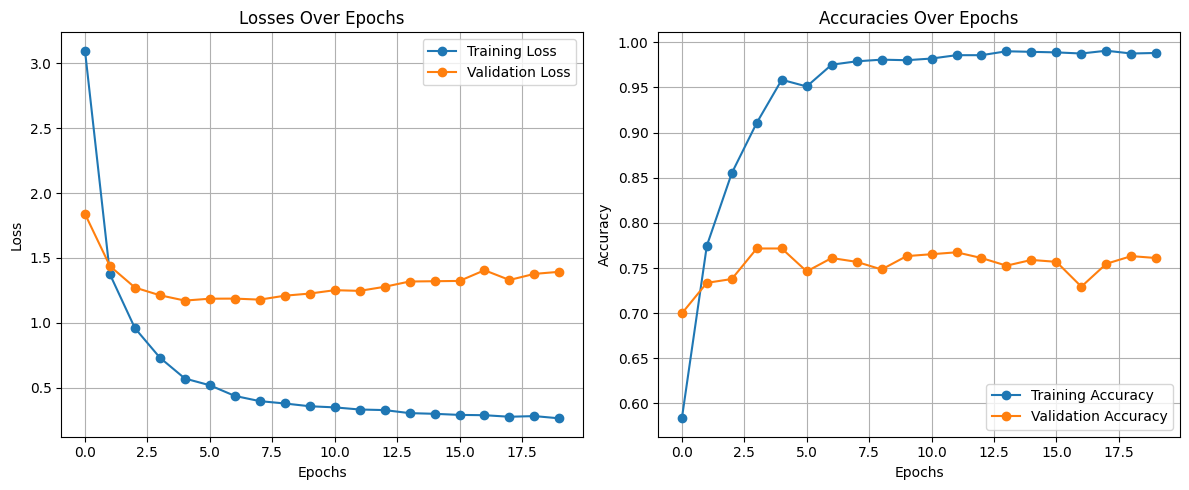

In [116]:
# Plotting Losses and Accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracies Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Evaluate Performance on Test Data

In [117]:
# Initialize lists for test metrics
test_losses = []
test_accuracies = []

# Testing Phase
model.eval()  # Set model to evaluation mode
running_test_loss = 0.0
test_all_labels = []
test_all_preds = []

with torch.no_grad():
    for image, seg, merged_label in testloader:  # Assuming you have a test data loader
        images = image.to(device)
        segmentation_masks = F.one_hot(seg.long(), num_classes=n_segmentation_classes).permute(0, 3, 1, 2).float().to(device)
        segmentation_targets = seg.long().to(device)  # Targets should be class indices (LongTensor)
        labels = merged_label.to(device)

        # Forward pass
        classification_output, segmentation_output = model(images)

        # Compute losses
        loss_classifier = criterion_classifier(classification_output, labels)
        loss_segmentation = criterion_segmentation(segmentation_output, segmentation_targets)
        total_test_loss = loss_classifier + loss_segmentation

        # Update test loss
        running_test_loss += total_test_loss.item()

        # Collect predictions for metrics
        preds = torch.argmax(classification_output, dim=1)
        test_all_labels.extend(labels.cpu().numpy())
        test_all_preds.extend(preds.cpu().numpy())

# Calculate test metrics
test_loss = running_test_loss / len(testloader)
test_accuracy = accuracy_score(test_all_labels, test_all_preds)
test_f1 = f1_score(test_all_labels, test_all_preds, average='weighted')

# Print test metrics
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}')

# Store metrics for plotting
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

Test Loss: 1.5669, Test Accuracy: 0.7246, Test F1 Score: 0.7192
